# Imports

In [1]:
import pygame
import random
import os
import time
import neat
import numpy as np

pygame.font.init()

pygame 2.4.0 (SDL 2.26.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Constants

In [2]:
WINDOW_WIDTH = 800
WINDOW_HEIGHT = 800
FLOOR = 730
STATS_FONT = pygame.font.SysFont("impact", 50)
END_FONT = pygame.font.SysFont("impact", 70)
DRAW_LINES = False
WIN = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
pygame.display.set_caption("Flappy Bird")

# Loading in Images

In [3]:
pipe_img = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","pipe.png")).convert_alpha())
bg_img = pygame.transform.scale(pygame.image.load(os.path.join("imgs","bg.jpg")).convert_alpha(), (WINDOW_WIDTH, WINDOW_HEIGHT))
bird_images = [pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird" + str(x) + ".png"))) for x in range(1,4)]
base_img = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","base.png")).convert_alpha())

gen = 0

# Bird Class

In [4]:
class bird_class:
    max_rotate = 25
    images = bird_images
    rotate_vel = 20
    ani_time = 5

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.tilt = 0  # degrees to tilt
        self.tick_count = 0
        self.vel = 0
        self.height = self.y
        self.img_count = 0
        self.img = self.images[0]

    def jump(self):
        self.vel = -10.5
        self.tick_count = 0
        self.height = self.y

    def move(self):

        self.tick_count += 1

        # for downward acceleration
        displacement = self.vel*(self.tick_count) + 0.5*(3)*(self.tick_count)**2  # calculate displacement

        # terminal velocity
        if displacement >= 16:
            displacement = (displacement/abs(displacement)) * 16

        if displacement < 0:
            displacement -= 2

        self.y = self.y + displacement

        if displacement < 0 or self.y < self.height + 50:  # tilt up
            if self.tilt < self.max_rotate:
                self.tilt = self.max_rotate
        else:  # tilt down
            if self.tilt > -90:
                self.tilt -= self.rotate_vel

    def draw(self, win):
        """
        draw the bird
        :param win: pygame window or surface
        :return: None
        """
        self.img_count += 1

        # For animation of bird, loop through three images
        if self.img_count <= self.ani_time:
            self.img = self.images[0]
        elif self.img_count <= self.ani_time*2:
            self.img = self.images[1]
        elif self.img_count <= self.ani_time*3:
            self.img = self.images[2]
        elif self.img_count <= self.ani_time*4:
            self.img = self.images[1]
        elif self.img_count == self.ani_time*4 + 1:
            self.img = self.images[0]
            self.img_count = 0

        # so when bird is nose diving it isn't flapping
        if self.tilt <= -80:
            self.img = self.images[1]
            self.img_count = self.ani_time*2


        # tilt the bird
        blitRotateCenter(win, self.img, (self.x, self.y), self.tilt)

    def get_mask(self):
        return pygame.mask.from_surface(self.img)

# Pipe Class

In [5]:
class Pipe():
    GAP = 200
    VEL = 5

    def __init__(self, x):
        self.x = x
        self.height = 0

        # where the top and bottom of the pipe is
        self.top = 0
        self.bottom = 0

        self.PIPE_TOP = pygame.transform.flip(pipe_img, False, True)
        self.PIPE_BOTTOM = pipe_img

        self.passed = False

        self.set_height()

    def set_height(self):
        self.height = random.randrange(50, 450)
        self.top = self.height - self.PIPE_TOP.get_height()
        self.bottom = self.height + self.GAP

    def move(self):
        self.x -= self.VEL

    def draw(self, win):
        win.blit(self.PIPE_TOP, (self.x, self.top))
        win.blit(self.PIPE_BOTTOM, (self.x, self.bottom))


    def collide(self, bird, win):
        bird_mask = bird.get_mask()
        top_mask = pygame.mask.from_surface(self.PIPE_TOP)
        bottom_mask = pygame.mask.from_surface(self.PIPE_BOTTOM)
        top_offset = (self.x - bird.x, self.top - round(bird.y))
        bottom_offset = (self.x - bird.x, self.bottom - round(bird.y))

        b_point = bird_mask.overlap(bottom_mask, bottom_offset)
        t_point = bird_mask.overlap(top_mask,top_offset)

        if b_point or t_point:
            return True

        return False

# Base Class

In [6]:
class Base:
    VEL = 5
    WIDTH = base_img.get_width()
    IMG = base_img

    def __init__(self, y):
        self.y = y
        self.x1 = 0
        self.x2 = self.WIDTH

    def move(self):
        self.x1 -= self.VEL
        self.x2 -= self.VEL
        if self.x1 + self.WIDTH < 0:
            self.x1 = self.x2 + self.WIDTH

        if self.x2 + self.WIDTH < 0:
            self.x2 = self.x1 + self.WIDTH

    def draw(self, win):
        win.blit(self.IMG, (self.x1, self.y))
        win.blit(self.IMG, (self.x2, self.y))

# Utility Functions

In [7]:
def blitRotateCenter(surf, image, topleft, angle):
    rotated_image = pygame.transform.rotate(image, angle)
    new_rect = rotated_image.get_rect(center = image.get_rect(topleft = topleft).center)

    surf.blit(rotated_image, new_rect.topleft)

def draw_window(win, birds, pipes, base, score, gen, pipe_ind):
    if gen == 0:
        gen = 1
    win.blit(bg_img, (0,0))

    for pipe in pipes:
        pipe.draw(win)

    base.draw(win)
    for bird in birds:
        # draw lines from bird to pipe
        if DRAW_LINES:
            try:
                pygame.draw.line(win, (255,0,0), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_TOP.get_width()/2, pipes[pipe_ind].height), 5)
                pygame.draw.line(win, (255,0,0), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_BOTTOM.get_width()/2, pipes[pipe_ind].bottom), 5)
            except:
                pass
        # draw bird
        bird.draw(win)

    # score
    score_label = STATS_FONT.render("Score: " + str(score),1,(0,0,0))
    win.blit(score_label, (WINDOW_WIDTH - score_label.get_width() - 15, 10))

    # generations
    score_label = STATS_FONT.render("Gens: " + str(gen-1),1,(0,0,0))
    win.blit(score_label, (10, 10))

    # alive
    score_label = STATS_FONT.render("Alive: " + str(len(birds)),1,(0,0,0))
    win.blit(score_label, (10, 50))

    pygame.display.update()

# Evaluation Genomes

In [8]:
def eval_genomes(genomes, config):
    global WIN, gen
    win = WIN
    gen += 1
    nets = []
    birds = []
    ge = []
    bird_start_times = {}  
    bird_pipe_counts = {}  
    total_lifespan = 0  

    bird_inputs = {}  # dictionary to store inputs for each bird
    bird_outputs = {}  # dictionary to store outputs for each bird

    for genome_id, genome in genomes:
        genome.fitness = 0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nets.append(net)
        birds.append(bird_class(230,350))
        ge.append(genome)
        bird_start_times[genome_id] = time.time()  
        bird_pipe_counts[genome_id] = 0  

        bird_inputs[genome_id] = []  # initialize list to store inputs for this bird
        bird_outputs[genome_id] = []  # initialize list to store outputs for this bird

    base = Base(FLOOR)
    pipes = [Pipe(700)]
    score = 0

    clock = pygame.time.Clock()

    run = True
    while run and len(birds) > 0:
        clock.tick(600)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()
                quit()
                break

        pipe_ind = 0
        if len(birds) > 0:
            if len(pipes) > 1 and birds[0].x > pipes[0].x + pipes[0].PIPE_TOP.get_width():
                pipe_ind = 1                                                                

        for x, bird in enumerate(birds):
            ge[x].fitness += 0.1
            bird.move()

            # inputs for the network
            inputs = (bird.y, abs(bird.y - pipes[pipe_ind].height), abs(bird.y - pipes[pipe_ind].bottom))
            output = nets[birds.index(bird)].activate(inputs)

            # store inputs and output for this bird
            bird_inputs[ge[x].key].append(inputs)
            bird_outputs[ge[x].key].append(output[0])

            if output[0] > 0.5:
                bird.jump()

        base.move()

        rem = []
        add_pipe = False
        for pipe in pipes:
            pipe.move()
            for bird in birds:
                if pipe.collide(bird, win):
                    ge[birds.index(bird)].fitness -= 1
                    nets.pop(birds.index(bird))
                    ge.pop(birds.index(bird))
                    birds.pop(birds.index(bird))

            if pipe.x + pipe.PIPE_TOP.get_width() < 0:
                rem.append(pipe)

            if not pipe.passed and pipe.x < bird.x:
                pipe.passed = True
                add_pipe = True
                for x, bird in enumerate(birds):
                    bird_pipe_counts[ge[x].key] += 1  
                    if bird_pipe_counts[ge[x].key] >= 50:
                        run = False
                        break

        if not run:
            break

        if add_pipe:
            score += 1
            for genome in ge:
                genome.fitness += 5
            pipes.append(Pipe(WINDOW_WIDTH))

        for r in rem:
            pipes.remove(r)

        for bird in birds:
            if bird.y + bird.img.get_height() - 10 >= FLOOR or bird.y < -50:
                bird_end_time = time.time()  
                bird_lifetime = bird_end_time - bird_start_times[genome_id]  
                total_lifespan += bird_lifetime  
                nets.pop(birds.index(bird))
                ge.pop(birds.index(bird))
                birds.pop(birds.index(bird))

        draw_window(WIN, birds, pipes, base, score, gen, pipe_ind)

    avg_lifespan_seconds = total_lifespan / len(genomes)  
    avg_pipes_passed = score / len(genomes)  

    print(f"Average lifespan: {avg_lifespan_seconds} seconds")
    print(f"Average pipes passed: {avg_pipes_passed}")

    return bird_inputs, bird_outputs

# main

In [9]:
def run(config_file):
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    # Initialize a counter for the number of generations
    num_generations = 0

    # Modify the run function to increment the counter each time a new generation is created
    def eval_genomes_incrementing(genomes, config):
        nonlocal num_generations
        num_generations += 1
        return eval_genomes(genomes, config)

    winner = p.run(eval_genomes_incrementing, 10)  # Run for one generation at a time

    # show final stats
    winner_network = neat.nn.FeedForwardNetwork.create(winner, config)

    return stats, winner, config, winner_network, num_generations



# run simulation

In [10]:
if __name__ == '__main__':
    local_dir = os.getcwd()
    # config_path = os.path.join(local_dir, 'config-feedforward.txt')
    config_path = os.path.join(local_dir, 'config2-feedforward.txt')
    run(config_path)
    stats, winner, config, winner_network, num_generations = run(config_path)


 ****** Running generation 0 ****** 

Average lifespan: 0.22802655696868895 seconds
Average pipes passed: 0.0
Population's average fitness: 4.08000 stdev: 1.69635
Best fitness: 7.30000 - size: (1, 3) - species 1 - id 10
Average adjusted fitness: 0.343
Mean genetic distance 1.122, standard deviation 0.501
Population of 10 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    10      7.3    0.343     0
Total extinctions: 0
Generation time: 0.589 sec

 ****** Running generation 1 ****** 

Average lifespan: 0.134531831741333 seconds
Average pipes passed: 0.0
Population's average fitness: 4.33000 stdev: 2.07415
Best fitness: 7.60000 - size: (1, 2) - species 1 - id 20
Average adjusted fitness: 0.371
Mean genetic distance 1.264, standard deviation 0.552
Population of 10 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    10      7.6    0.371     0
Total exti

range(0, 10)
10
[ 4.7  85.16 85.17 85.17 85.63 85.18 85.17 85.17 85.06 85.6 ]
Generation: range(0, 10)


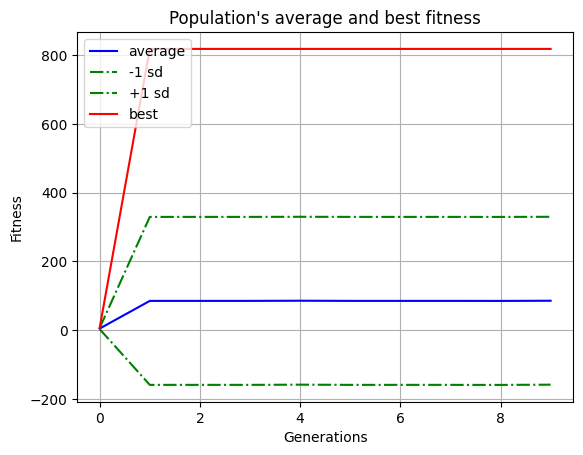

In [11]:
import visualize
print(range(len(stats.most_fit_genomes)))
print(num_generations)
print(np.array(stats.get_fitness_mean()))
visualize.plot_stats(stats, num_generations, ylog=False, view=True)